# The Retriever

In [144]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [145]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [146]:
import datasets
subjqa = datasets.load_dataset("subjqa", name = "electronics")

  0%|          | 0/3 [00:00<?, ?it/s]

In [147]:
subjqa_test = subjqa['test']

In [148]:
!pip install sentence_transformers
from sentence_transformers import SentenceTransformer, util

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [149]:
subjqa_test_contexts = subjqa_test['context']
subjqa_test_questions = subjqa_test['question']
subjqa_test_answers = subjqa_test['answers']

In [150]:
from torch.nn import CosineSimilarity
import numpy as np

def retrieve(query, bi_encoder, context_embeddings, top_k_return):
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    cos = CosineSimilarity(dim=1, eps=1e-6)
    query_cosine_similarities_with_contexts = cos(question_embedding, context_embeddings).cpu()
    top_k_context_idx_reversed = np.array(query_cosine_similarities_with_contexts.argsort()[-top_k_return:])
    top_k_context_idx = top_k_context_idx_reversed[::-1]

    return top_k_context_idx

Evaluating pre-trained bi-encoder

In [151]:
bi_encoder = SentenceTransformer('sentence-transformers/multi-qa-MiniLM-L6-cos-v1')
context_embeddings = bi_encoder.encode(subjqa_test_contexts, convert_to_tensor=True, show_progress_bar=True)

loading configuration file /root/.cache/torch/sentence_transformers/sentence-transformers_multi-qa-MiniLM-L6-cos-v1/config.json
Model config BertConfig {
  "_name_or_path": "/root/.cache/torch/sentence_transformers/sentence-transformers_multi-qa-MiniLM-L6-cos-v1/",
  "architectures": [
    "BertModel"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file /root/.cache/torch/sentence_transformers/sentence-transformers_multi-qa-MiniLM-L6-cos-v1/pytorch_model.bin
All model checkpoi

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [152]:
all_k = (1, 3, 5, 10, 20, 40, 80, 100, 160, 200)

recalls = {}
for k in all_k:
  recalls[k] = []

# first retrieve the top k relevant docs for each question using bi-encoder
# and then for each value of k, check if the true context is present in the 
# top-k retrieved contexts
for test_question_idx in range(len(subjqa_test_questions)):
  test_question = subjqa_test_questions[test_question_idx]
  all_top_idx = retrieve(test_question, bi_encoder, context_embeddings, np.max(all_k))

  for k in all_k:
    top_k_idx = all_top_idx[:k]
    if test_question_idx in top_k_idx:
      recalls[k].append(1)
    else:
      recalls[k].append(0)

mean_recalls_pretrained = {k: np.mean(recalls[k])*100 for k in all_k}

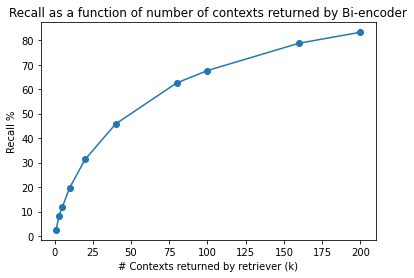

In [153]:
from matplotlib import pyplot as plt

plt.plot(list(mean_recalls_pretrained.keys()), list(mean_recalls_pretrained.values()), marker='o')
plt.xlabel('# Contexts returned by retriever (k)')
plt.ylabel("Recall %")
plt.title("Recall as a function of number of contexts returned by Bi-encoder")

plt.show()

Fine-tuning the bi-encoder on subjqa train dataset

In [154]:
subjqa_train = subjqa['train']

In [155]:
from sentence_transformers import InputExample
from tqdm.auto import tqdm

train = []
for row in tqdm(subjqa_train):
    train.append(InputExample(
        texts=[row['question'], row['context']]
    ))

  0%|          | 0/1295 [00:00<?, ?it/s]

In [156]:
from sentence_transformers import datasets

batch_size = 24

dataloader = datasets.NoDuplicatesDataLoader(train, batch_size=batch_size)

In [157]:
from sentence_transformers import losses

mnrloss = losses.MultipleNegativesRankingLoss(bi_encoder)

In [158]:
epochs = 3
warmup_steps = int(len(dataloader) * epochs * 0.1)

bi_encoder.fit(
    train_objectives=[(dataloader, mnrloss)],
    epochs=epochs,
    warmup_steps=warmup_steps,
    output_path='bi_encoder_finetuned_subjqa_electronics',
    show_progress_bar=True
)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/53 [00:00<?, ?it/s]

Iteration:   0%|          | 0/53 [00:00<?, ?it/s]

Iteration:   0%|          | 0/53 [00:00<?, ?it/s]

Configuration saved in bi_encoder_finetuned_subjqa_electronics/config.json
Model weights saved in bi_encoder_finetuned_subjqa_electronics/pytorch_model.bin
tokenizer config file saved in bi_encoder_finetuned_subjqa_electronics/tokenizer_config.json
Special tokens file saved in bi_encoder_finetuned_subjqa_electronics/special_tokens_map.json


In [159]:
context_embeddings = bi_encoder.encode(subjqa_test_contexts, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

In [160]:
all_k = (1, 3, 5, 10, 20, 40, 80, 100, 160, 200)

recalls = {}
for k in all_k:
  recalls[k] = []

# first retrieve the top k relevant docs for each question using bi-encoder
# and then for each value of k, check if the true context is present in the 
# top-k retrieved contexts
for test_question_idx in range(len(subjqa_test_questions)):
  test_question = subjqa_test_questions[test_question_idx]
  all_top_idx = retrieve(test_question, bi_encoder, context_embeddings, np.max(all_k))

  for k in all_k:
    top_k_idx = all_top_idx[:k]
    if test_question_idx in top_k_idx:
      recalls[k].append(1)
    else:
      recalls[k].append(0)

mean_recalls_finetuned = {k: np.mean(recalls[k])*100 for k in all_k}

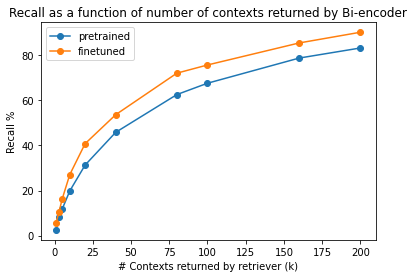

In [161]:
from matplotlib import pyplot as plt

plt.plot(list(mean_recalls_pretrained.keys()), list(mean_recalls_pretrained.values()), marker='o', label='pretrained')
plt.plot(list(mean_recalls_finetuned.keys()), list(mean_recalls_finetuned.values()), marker='o', label='finetuned')
plt.xlabel('# Contexts returned by retriever (k)')
plt.ylabel("Recall %")
plt.title("Recall as a function of number of contexts returned by Bi-encoder")
plt.legend()

plt.show()

# Re-ranking using cross-encoder

In [162]:
def retrieveAndReRank(query, bi_encoder, cross_encoder, context_embeddings, top_k_return, top_k_biencoder):
    # retrieve using bi-encoder
    question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
    question_embedding = question_embedding.cuda()
    cos = CosineSimilarity(dim=1, eps=1e-6)
    query_cosine_similarities_with_contexts = cos(question_embedding, context_embeddings).cpu()
    top_k_context_idx_reversed = np.array(query_cosine_similarities_with_contexts.argsort()[-top_k_biencoder:])
    top_k_context_idx = top_k_context_idx_reversed[::-1]

    # re-rank using cross-encoder
    cross_encoder_scores = {index: cross_encoder.predict([query, subjqa_test_contexts[index]]) for index in top_k_context_idx}
    cross_encoder_scores_sorted = {k: v for k, v in sorted(cross_encoder_scores.items(), key=lambda item: item[1], reverse=True)}
    re_ranked_idx = list(cross_encoder_scores_sorted.keys())

    re_ranked_idx_return = re_ranked_idx[:top_k_return]

    return re_ranked_idx_return

In [163]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [164]:
from sentence_transformers import CrossEncoder
# cross_encoder = CrossEncoder(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2', num_labels=1, max_length=512, device='cuda')
cross_encoder = CrossEncoder(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=256)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cross-encoder--ms-marco-MiniLM-L-6-v2/snapshots/b2cfda50a1a9fc7919e7444afbb52610d268af92/config.json
Model config BertConfig {
  "_name_or_path": "cross-encoder/ms-marco-MiniLM-L-6-v2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sbert_ce_default_activation_function": "torch.nn.modules.linear.Identity",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use

In [165]:
all_k = (1, 3, 5, 10, 20, 40, 80, 100)

recalls = {}
for k in all_k:
  recalls[k] = []

# first retrieve the top k relevant docs for each question using bi-encoder
# and then for each value of k, check if the true context is present in the 
# top-k retrieved contexts
for test_question_idx in tqdm(range(len(subjqa_test_questions))):
  test_question = subjqa_test_questions[test_question_idx]
  all_top_idx = retrieveAndReRank(test_question, bi_encoder, cross_encoder, context_embeddings, np.max(all_k), 100)

  for k in all_k:
    top_k_idx = all_top_idx[:k]
    if test_question_idx in top_k_idx:
      recalls[k].append(1)
    else:
      recalls[k].append(0)

mean_recalls_crossencoder_pretrained = {k: np.mean(recalls[k])*100 for k in all_k}

  0%|          | 0/358 [00:00<?, ?it/s]

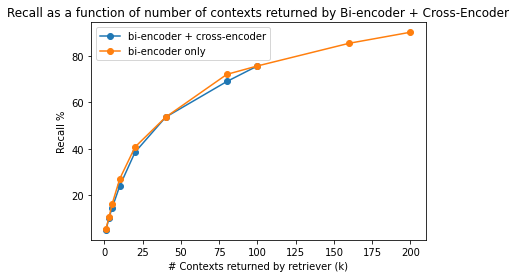

In [166]:
from matplotlib import pyplot as plt

plt.plot(list(mean_recalls_crossencoder_pretrained.keys()), list(mean_recalls_crossencoder_pretrained.values()), marker='o', label='bi-encoder + cross-encoder')
plt.plot(list(mean_recalls_finetuned.keys()), list(mean_recalls_finetuned.values()), marker='o', label='bi-encoder only')
plt.xlabel('# Contexts returned by retriever (k)')
plt.ylabel("Recall %")
plt.title("Recall as a function of number of contexts returned by Bi-encoder + Cross-Encoder")
plt.legend()

plt.show()

Fine-tune Cross-Encoder

In [167]:
# get training data
subjqa_train = subjqa['train']
subjqa_train_questions = subjqa_train['question']
subjqa_train_contexts = subjqa_train['context']
subjqa_train_answers = subjqa_train['answers']
subjqa_train_answers_text = [answer['text'] for answer in subjqa_train_answers]
train_labels = [1 for text in subjqa_train_answers_text]
print(subjqa_train_answers_text)
print(train_labels)

[[], ['Bass is weak as expected', 'Bass is weak as expected, even with EQ adjusted up'], ['The only fault in the sound is the bass'], ['the best of all of them'], ['The sound is so crisp', 'crazy obsession with sound and music'], ['that had terrible bass', 'This is my first review for the Sony MDR'], [], [], [], ['The instructions were clear'], ['strap is fairly', 'the bass is awesome'], ['comfortable', 'The earphones are fairly comfortable'], [], ['crystal clear and BIG. Bass booms'], [], ['expensive but terrible set of headphones', 'terrible set of headphones'], [], [], ['absolutely mind blowing', 'Music is crisp and clear and base can be felt in your bones'], ["These headphones aren't very"], [], ['super simple', 'the power to the hub'], [], ['These headphones were too big', 'These headphones were too big for my head'], [], ['The headphones are comfortable'], ['The image quality is amazing at this price point', 'The image quality is amazing at this price point'], ['a nice low cost p

In [168]:
len(subjqa_train_questions)

1295

In [169]:
# create negative examples
NUM_NEGATIVE_EXAMPLES = 5

import numpy as np

all_train_questions = []
all_train_contexts = []
all_train_labels = []

all_training_samples = list(range(len(subjqa_train_questions)))
for i in range(len(subjqa_train_questions)):
  all_training_samples_except_this = all_training_samples.copy()
  all_training_samples_except_this.remove(i)
  sample_negative_examples_idx = np.random.choice(all_training_samples_except_this, NUM_NEGATIVE_EXAMPLES)

  # add positive example
  all_train_questions.append(subjqa_train_questions[i])
  all_train_contexts.append(subjqa_train_contexts[i])
  all_train_labels.append(1)

  # add negative examples
  for idx in sample_negative_examples_idx:
    all_train_questions.append(subjqa_train_questions[i])
    all_train_contexts.append(subjqa_train_contexts[idx])
    all_train_labels.append(0)


In [170]:
# training data loader
from sentence_transformers import InputExample
train_samples = [InputExample(texts=[question, context], label=label) for question, context, label in zip(all_train_questions, all_train_contexts, all_train_labels)]

from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=16)

In [171]:
# evaluator
from sentence_transformers.cross_encoder.evaluation import CEBinaryClassificationEvaluator

subjqa_validation = subjqa['validation']
subjqa_validation_questions = subjqa_validation['question']
subjqa_validation_contexts = subjqa_validation['context']
subjqa_validation_answers = subjqa_validation['answers']

In [172]:
# create negative examples
NUM_NEGATIVE_EXAMPLES = 5

import numpy as np

all_val_questions = []
all_val_contexts = []
all_val_labels = []

all_val_samples = list(range(len(subjqa_validation_questions)))
for i in range(len(subjqa_validation_questions)):
  all_val_samples_except_this = all_val_samples.copy()
  all_val_samples_except_this.remove(i)
  sample_negative_examples_idx = np.random.choice(all_val_samples_except_this, NUM_NEGATIVE_EXAMPLES)

  # add positive example
  all_val_questions.append(subjqa_validation_questions[i])
  all_val_contexts.append(subjqa_validation_contexts[i])
  all_val_labels.append(1)

  # add negative examples
  for idx in sample_negative_examples_idx:
    all_val_questions.append(subjqa_validation_questions[i])
    all_val_contexts.append(subjqa_validation_contexts[idx])
    all_val_labels.append(0)

In [173]:
evaluator = CEBinaryClassificationEvaluator(list(zip(all_val_questions, all_val_contexts)), all_val_labels)

In [174]:
all_learning_rates = [1e-4]#[1e-1, 1e-2, 1e-3, 1e-4]
all_weight_decays = [1e-3]#[1e-4, 1e-5, 1e-3, 0]

In [175]:
# train model (hyperparameter search)
model_scores = {}
for learning_rate in all_learning_rates:
  for weight_decay in all_weight_decays:
    output_path = f"gdrive/My Drive/DS405B_NLP/assignment_4/cross_encoder_lr={learning_rate}_wd={weight_decay}"

    # try:  # if the model with these hyperparameters already exists, load it
    #   cross_encoder = CrossEncoder(output_path)
    #   model_score = evaluator(cross_encoder)
    #   model_scores[model_score] = cross_encoder

    # except: # else, train the model
      # print()
    epochs = 1
    cross_encoder = CrossEncoder(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2', num_labels=1, max_length=512, device='cuda')
    cross_encoder.fit(train_dataloader=train_dataloader,
                      evaluator=evaluator,
                      epochs=epochs,
                      warmup_steps=int(len(train_dataloader)*epochs*0.1),
                      evaluation_steps=500, 
                      output_path=output_path,
                      weight_decay=weight_decay,
                      optimizer_params={'lr': learning_rate},
                      save_best_model=True)
    model_score = cross_encoder.best_score
    model_scores[model_score] = cross_encoder

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cross-encoder--ms-marco-MiniLM-L-6-v2/snapshots/b2cfda50a1a9fc7919e7444afbb52610d268af92/config.json
Model config BertConfig {
  "_name_or_path": "cross-encoder/ms-marco-MiniLM-L-6-v2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sbert_ce_default_activation_function": "torch.nn.modules.linear.Identity",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/486 [00:00<?, ?it/s]

Configuration saved in gdrive/My Drive/DS405B_NLP/assignment_4/cross_encoder_lr=0.0001_wd=0.001/config.json
Model weights saved in gdrive/My Drive/DS405B_NLP/assignment_4/cross_encoder_lr=0.0001_wd=0.001/pytorch_model.bin
tokenizer config file saved in gdrive/My Drive/DS405B_NLP/assignment_4/cross_encoder_lr=0.0001_wd=0.001/tokenizer_config.json
Special tokens file saved in gdrive/My Drive/DS405B_NLP/assignment_4/cross_encoder_lr=0.0001_wd=0.001/special_tokens_map.json


In [176]:
model_scores

{0.5872435424661342: <sentence_transformers.cross_encoder.CrossEncoder.CrossEncoder at 0x7f6caa5ec040>}

In [177]:
# select the model with the highest score
best_model_score = max(model_scores)
best_cross_encoder = model_scores[best_model_score]

In [178]:
np.argmax(model_scores)

0

In [179]:
cross_encoder_pretrained = CrossEncoder(model_name='cross-encoder/ms-marco-MiniLM-L-6-v2', max_length=512)
pretrained_score = evaluator(cross_encoder_pretrained)
print("evaluation score of pre-trained model: ", pretrained_score)
print('evaluation score of best model after fine-tuning: ', best_model_score)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--cross-encoder--ms-marco-MiniLM-L-6-v2/snapshots/b2cfda50a1a9fc7919e7444afbb52610d268af92/config.json
Model config BertConfig {
  "_name_or_path": "cross-encoder/ms-marco-MiniLM-L-6-v2",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "sbert_ce_default_activation_function": "torch.nn.modules.linear.Identity",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use

evaluation score of pre-trained model:  0.40640412782280266
evaluation score of best model after fine-tuning:  0.5872435424661342


Evaluate Cross-Encoder

In [180]:
all_k = (1, 3, 5, 10, 20, 40, 80, 100)

recalls = {}
for k in all_k:
  recalls[k] = []

# first retrieve the top k relevant docs for each question using bi-encoder
# and then for each value of k, check if the true contexjhjht is present in the 
# top-k retrieved contexts
for test_question_idx in tqdm(range(len(subjqa_test_questions))):
  test_question = subjqa_test_questions[test_question_idx]
  all_top_idx = retrieveAndReRank(test_question, bi_encoder, best_cross_encoder, context_embeddings, np.max(all_k), 100)

  for k in all_k:
    top_k_idx = all_top_idx[:k]
    if test_question_idx in top_k_idx:
      recalls[k].append(1)
    else:
      recalls[k].append(0)

mean_recalls_crossencoder_finetuned = {k: np.mean(recalls[k])*100 for k in all_k}

  0%|          | 0/358 [00:00<?, ?it/s]

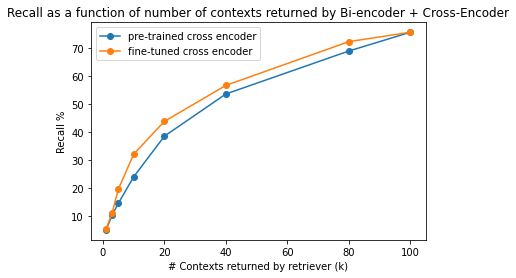

In [181]:

from matplotlib import pyplot as plt

plt.plot(list(mean_recalls_crossencoder_pretrained.keys()), list(mean_recalls_crossencoder_pretrained.values()), marker='o', label='pre-trained cross encoder')
plt.plot(list(mean_recalls_crossencoder_finetuned.keys()), list(mean_recalls_crossencoder_finetuned.values()), marker='o', label='fine-tuned cross encoder')
plt.xlabel('# Contexts returned by retriever (k)')
plt.ylabel("Recall %")
plt.title("Recall as a function of number of contexts returned by Bi-encoder + Cross-Encoder")
plt.legend()

plt.show()

# Fine-tuning the reader

In [182]:
from transformers import AutoModelForQuestionAnswering,  AutoTokenizer, pipeline

reader_model_name = "deepset/minilm-uncased-squad2"

In [183]:
from transformers import AutoModelForQuestionAnswering,  AutoTokenizer, pipeline

reader_model_name = "deepset/minilm-uncased-squad2"
# reader = pipeline('question-answering', model=model_name, tokenizer=model_name)

In [184]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(reader_model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--deepset--minilm-uncased-squad2/snapshots/96785dbd59c4f67f564824ef7a1a165cec3414af/config.json
Model config BertConfig {
  "_name_or_path": "deepset/minilm-uncased-squad2",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--deepset--minilm-uncased-squad2/snapshots/96785dbd59c4f67f564

In [185]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        answer = answers[i]
        
        if len(answer['text']) != 0:
          start_char = answer["answer_start"][0]
          end_char = answer["answer_start"][0] + len(answer["text"][0])
          sequence_ids = inputs.sequence_ids(i)

          # Find the start and end of the context
          idx = 0
          while sequence_ids[idx] != 1:
              idx += 1
          context_start = idx
          while sequence_ids[idx] == 1:
              idx += 1
          context_end = idx - 1

          # If the answer is not fully inside the context, label it (0, 0)
          if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
              start_positions.append(0)
              end_positions.append(0)
          else:
              # Otherwise it's the start and end token positions
              idx = context_start
              while idx <= context_end and offset[idx][0] <= start_char:
                  idx += 1
              start_positions.append(idx - 1)

              idx = context_end
              while idx >= context_start and offset[idx][1] >= end_char:
                  idx -= 1
              end_positions.append(idx + 1)
        
        else:
          start_positions.append(0)
          end_positions.append(0)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [186]:
tokenized_subjqa = subjqa.map(preprocess_function, batched=True, remove_columns=subjqa["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [187]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

In [188]:
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer

model = AutoModelForQuestionAnswering.from_pretrained(reader_model_name)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--deepset--minilm-uncased-squad2/snapshots/96785dbd59c4f67f564824ef7a1a165cec3414af/config.json
Model config BertConfig {
  "_name_or_path": "deepset/minilm-uncased-squad2",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /root/.cache/huggingface/hub/models--deepset--minilm-uncased-squad2/snapshots/967

In [189]:
!pip install rouge
from rouge import Rouge

rouge = Rouge()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [190]:
training_args = TrainingArguments(
    output_dir="reader_finetuned",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=1e-3,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_subjqa['train'],
    eval_dataset=tokenized_subjqa["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 1295
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 243
  Number of trainable parameters = 33212930


Epoch,Training Loss,Validation Loss
1,No log,2.366412
2,No log,2.368141
3,No log,2.404818


***** Running Evaluation *****
  Num examples = 358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 358
  Batch size = 16
***** Running Evaluation *****
  Num examples = 358
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=243, training_loss=2.11413071871785, metrics={'train_runtime': 118.2866, 'train_samples_per_second': 32.844, 'train_steps_per_second': 2.054, 'total_flos': 190613345610240.0, 'train_loss': 2.11413071871785, 'epoch': 3.0})

Evaluating pre-trained reader

In [191]:
from transformers import pipeline

qa = pipeline(
    'question-answering',
    model="deepset/minilm-uncased-squad2",
    tokenizer=tokenizer,
    device=0
)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--deepset--minilm-uncased-squad2/snapshots/96785dbd59c4f67f564824ef7a1a165cec3414af/config.json
Model config BertConfig {
  "_name_or_path": "deepset/minilm-uncased-squad2",
  "architectures": [
    "BertForQuestionAnswering"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--deepset--minilm-uncased-squad2/snapshots/967

In [192]:
scores = []

for i in tqdm(range(len(subjqa_test))):
    out = qa({'question': subjqa_test['question'][i],
              'context': subjqa_test['context'][i]}
        )
    pred_answer = out['answer']

    true_answers = subjqa_test['answers'][i]['text']    
    # no true answer
    if len(true_answers) == 0:
      if len(pred_answer) == 0:
        scores.append(1)
      else:
        scores.append(0)

    # true answers exist
    else:
      temp = []
      for true_answer in true_answers:
        temp.append(rouge.get_scores(pred_answer, true_answer)[0]['rouge-1']['f'])
      
      scores.append(max(temp))

  0%|          | 0/358 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/base.py:1045: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


In [193]:
print('F-1 Score of pre-trained reader model', np.mean(scores))

F-1 Score of pre-trained reader model 0.12699941273429263


Evaluating finetuned reader

In [194]:
from transformers import pipeline

qa = pipeline(
    'question-answering',
    model=model,
    tokenizer=tokenizer,
    device=0
)

In [195]:
scores = []

for i in tqdm(range(len(subjqa_test))):
    out = qa({'question': subjqa_test['question'][i],
              'context': subjqa_test['context'][i]}
        )
    pred_answer = out['answer']

    true_answers = subjqa_test['answers'][i]['text']    
    # no true answer
    if len(true_answers) == 0:
      if len(pred_answer) == 0:
        scores.append(1)
      else:
        scores.append(0)

    # true answers exist
    else:
      temp = []
      for true_answer in true_answers:
        temp.append(rouge.get_scores(pred_answer, true_answer)[0]['rouge-1']['f'])
      
      scores.append(max(temp))

  0%|          | 0/358 [00:00<?, ?it/s]

In [196]:
print('F-1 Score of fine-tuned reader model', np.mean(scores))

F-1 Score of fine-tuned reader model 0.2718378722937531
